<img src='../img/acam_banner.png' alt='ACAM Training School' align='right' width='60%'></img>

<br>

<hr>

# VIIRS Level 1B - Calibrated Radiances - True Color RGB - 1km

### About

This module shows the structure of `VIIRS Level 1B` data and what information of the data files can be used in order to load, browse and visualize the data.

According to [NASA](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/s-npp-nasa-viirs-overview/#viirs-spectral-bands), "VIIRS is aboard two satellites: Suomi National Polar-orbiting Partnership (Suomi NPP) and National Oceanic and Atmospheric Administration-20 (NOAA-20). 

VIIRS observes the entire Earth’s surface twice each day crossing equator approximately 14 times each day per satellite. Suomi NPP crosses the equator about 1:30 a.m. and 1:30 p.m. and NOAA-20 crossing at 2:20 am and 2:20 pm, local time; from NPP’s polar orbit 824 kilometers (km) (512 miles) above the Earth’s surface. [...] The VIIRS instrument provides 22 spectral bands from 412 nanometers (nm) to 12 micrometers (µm) at two spatial resolutions, 375 meters (m) and 750 m, which are resampled to 500 m, 1 km, and 0.05 degrees in the NASA produced data products to promote consistency with the MODIS heritage."

This notebook features biomass burning events in Laos on 7 April 2023.

### Basic Facts

> **Spatial resolution**: `375m or 750m at nadir`<br>
> **Spatial coverage**: `Global` <br>
> **Revisit time**: `Daily` <br>
> **Data availability**: `since 2012`


### How to access the data

This notebook uses VIIRS Level 1B data from the SNPP platform. This data can be ordered via the [LAADS DAAC](https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/VNP02DNB--5200,VNP02IMG--5200,VNP02MOD--5200,VNP03DNB--5200,VNP03IMG--5200,VNP03MOD--5200) and are distributed in `netcdf` format.

Note that you need to also search for and download the 6 data files in order to get all the data you need to geolocate the data and create the full set of composites:
- [VNP02DNB - VIIRS/NPP Day/Night Band 6-Min L1B Swath 750m](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP02DNB) 
- [VVNP02IMG - VIIRS/NPP Imagery Resolution 6-Min L1B Swath 375m](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP02IMG)
- [VNP02MOD - VIIRS/NPP Moderate Resolution 6-Min L1B Swath 750m](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP02MOD) 
- [VNP03DNB - VIIRS/NPP Day/Night Band Moderate Resolution Terrain-Corrected Geolocation 6-Min L1 Swath 750m](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP03DNB)
- [VNP03IMG - VIIRS/NPP Imagery Resolution Terrain-Corrected Geolocation 6-Min L1 Swath 375m](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP03IMG)
- [VNP03MOD - VIIRS/NPP Moderate Resolution Terrain-Corrected Geolocation 6-Min L1 Swath 750m](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP03DNB)

The filenames for the same granule will have a common middle portion which reflects the date and time. For example, `A2023097.0606`. This means the file date and time is `2023-04-07 06:06:00`.

You need to [register for an Earthdata account](https://urs.earthdata.nasa.gov/) in order to be able to download data. Read [this webpage](https://ladsweb.modaps.eosdis.nasa.gov/tools-and-services/data-download-scripts/#wget) for more information on downloading data programmatically using `wget`.

### Module outline
- [1 - Load and browse VIIRS VVNP02IMG Level 1B data files](#viirs_load)
- [2 - Browse and visualize RGB composite IDs](#rgb_composites)
- [3 - Generate a geographical subset around Sardinia, Italy](#geographical_subset)
- [4 - Visualize VIIRS 'natural_color_raw' RGB composite with Cartopy features](#vis_natural)
- [5 - Visualize MODIS 'dust' RGB composite with Cartopy features](#vis_dust)

<hr>

#### Load required libraries

In [27]:
import glob
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.axes import Axes

import satpy
from satpy.scene import Scene
from satpy import find_files_and_readers
import pyresample as prs

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

#### Load helper functions

In [28]:
%run ../functions.ipynb

<hr>

## <a id='viirs_load'></a>1. Load and browse VIIRS Level 1B Calibrated Radiances data

From the [LAADS DAAC](https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/VVNP02IMGKM--61), we downloaded one tile of Level-1B Image data on 6 April 2023. The data is available in the folder `../../eodata/acam_training_school/VIIRS/`. Let us load the data. First, we specify the file path and create a variable with the name `file_name`.

In [29]:
file_names = glob.glob('../../eodata/acam_training_school/VIIRS/*A2023097*')
file_names

['../../eodata/acam_training_school/VIIRS/VNP02MOD.A2023097.0606.002.2023097154326.nc',
 '../../eodata/acam_training_school/VIIRS/VNP02IMG.A2023097.0606.002.2023097154326.nc',
 '../../eodata/acam_training_school/VIIRS/VNP03MOD.A2023097.0606.002.2023097150439.nc',
 '../../eodata/acam_training_school/VIIRS/VNP02DNB.A2023097.0606.002.2023097154326.nc',
 '../../eodata/acam_training_school/VIIRS/VNP03IMG.A2023097.0606.002.2023097150439.nc',
 '../../eodata/acam_training_school/VIIRS/VNP03DNB.A2023097.0606.002.2023097150439.nc']

<br>

In a next step, we use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for VIIRS Level-1B data, you can use the `viirs_l1b` reader.

In [30]:
scn =Scene(filenames=file_names,reader='viirs_l1b')
scn

<br>

A `Scene` object is a collection of different bands, with the function `available_dataset_names()`, you can see the available bands of the scene. To learn more about the bands of VIIRS, visit [this website](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/s-npp-nasa-viirs-overview/#viirs-spectral-bands).

In [31]:
scn.available_dataset_names()

['DNB',
 'I01',
 'I02',
 'I03',
 'I04',
 'I05',
 'M01',
 'M02',
 'M03',
 'M04',
 'M05',
 'M06',
 'M07',
 'M08',
 'M09',
 'M10',
 'M11',
 'M12',
 'M13',
 'M14',
 'M15',
 'M16',
 'dnb_lat',
 'dnb_lon',
 'dnb_lunar_azimuth_angle',
 'dnb_lunar_zenith_angle',
 'dnb_moon_illumination_fraction',
 'dnb_satellite_azimuth_angle',
 'dnb_satellite_zenith_angle',
 'dnb_solar_azimuth_angle',
 'dnb_solar_zenith_angle',
 'i_lat',
 'i_lon',
 'i_satellite_azimuth_angle',
 'i_satellite_zenith_angle',
 'i_solar_azimuth_angle',
 'i_solar_zenith_angle',
 'm_lat',
 'm_lon',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

<br>

The underlying container for data in satpy is the `xarray.DataArray`. With the function `load()`, you can specify an individual band by name, e.g. `I01` and *load* the data. If you then select the loaded band, you see that the band object is a `xarray.DataArray`. Band I01 has a bandwidth or wavelength of 0.6 - 0.68μm.

In [32]:
scn.load(['I01'])
scn['I01']

<xarray.DataArray 'I01' (y: 6464, x: 6400)>
dask.array<add, shape=(6464, 6400), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    crs      object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes:
    start_orbit:            59288
    end_orbit:              59288
    long_name:              I-band 01 observations at pixel locations
    _FillValue:             65535
    valid_min:              0
    valid_max:              65527
    scale_factor:           1.9991758e-05
    add_offset:             0.0
    radiance_scale_factor:  0.0103689125
    radiance_add_offset:    0.0
    radiance_units:         Watts/meter^2/steradian/micrometer
    name:                   I01
    wavelength:             0.64 µm (0.6-0.68 µm)
    resolution:             371
    calibration:            reflectance
    coordinates:            ('i_lon', 'i_lat')
    file_type:              vl1bi
    standard_name:          toa_bidirectional_reflectance
    units:                  %
    modifiers:              ()
    rows_per_scan:          32
    shape:                  (6464, 6400)
    file_units:             1
    platform_name:          Suomi-NPP
    sensor:                 VIIRS
    start_time:             2023-04-07 06:06:00
    end_time:               2023-04-07 06:12:00
    reader:                 viirs_l1b
    area:                   Shape: (6464, 6400)\nLons: <xarray.DataArray 'lon...
    _satpy_id:              DataID(name='I01', wavelength=WavelengthRange(min...
    ancillary_variables:    []

<br>

With an xarray data structure, you can handle the object as a `xarray.DataArray`. For example, you can print a list of available attributes with the function `attrs.keys()`. 

In [33]:
scn['I01'].attrs.keys()

dict_keys(['start_orbit', 'end_orbit', 'long_name', '_FillValue', 'valid_min', 'valid_max', 'scale_factor', 'add_offset', 'radiance_scale_factor', 'radiance_add_offset', 'radiance_units', 'name', 'wavelength', 'resolution', 'calibration', 'coordinates', 'file_type', 'standard_name', 'units', 'modifiers', 'rows_per_scan', 'shape', 'file_units', 'platform_name', 'sensor', 'start_time', 'end_time', 'reader', 'area', '_satpy_id', 'ancillary_variables'])

<br>

With the `attrs()` function, you can also access individual metadata information, e.g. `start_time` and `end_time`.

In [34]:
scn['I01'].start_time, scn['I01'].end_time

(datetime.datetime(2023, 4, 7, 6, 6), datetime.datetime(2023, 4, 7, 6, 12))

<br>

## <a id='rgb_composites'></a> 2. Browse and visualize RGB composite IDs

RGB composites combine different channels of satellite data in order to get e.g. a true-color image of the scene. Depending on which channel combination is used, different features can be highlighted in the composite, e.g. dust. SatPy offers several predefined RGB composite options. The function `available_composite_ids()` returns a list of available composite IDs.

In [35]:
scn.available_composite_ids()

[DataID(name='adaptive_dnb'),
 DataID(name='ash'),
 DataID(name='cloudtop'),
 DataID(name='cloudtop_daytime'),
 DataID(name='day_microphysics'),
 DataID(name='dust'),
 DataID(name='dynamic_dnb'),
 DataID(name='false_color'),
 DataID(name='fire_temperature'),
 DataID(name='fire_temperature_39refl'),
 DataID(name='fire_temperature_awips'),
 DataID(name='fire_temperature_eumetsat'),
 DataID(name='fog'),
 DataID(name='green_snow'),
 DataID(name='histogram_dnb'),
 DataID(name='hncc_dnb'),
 DataID(name='hr_cloudtop_daytime'),
 DataID(name='hr_overview'),
 DataID(name='ir108_3d'),
 DataID(name='ir_cloud_day'),
 DataID(name='natural_color'),
 DataID(name='natural_color_raw'),
 DataID(name='natural_color_sun_lowres'),
 DataID(name='natural_enh'),
 DataID(name='natural_with_night_fog'),
 DataID(name='night_fog'),
 DataID(name='night_microphysics'),
 DataID(name='night_overview'),
 DataID(name='ocean_color'),
 DataID(name='overview'),
 DataID(name='overview_raw'),
 DataID(name='snow_age'),
 DataI

<br>

Let us define a list with the composite ID `natural_color`. This list (`composite_id`) can then be passed to the function `load()`. Per default, scenes are loaded with the north pole facing downwards. You can specify the keyword argument `upper_right_corner='NE'` in order to turn the image around and have the north pole facing upwards.

In [39]:
composite_ids = ['natural_color']
scn.load(composite_ids)

<br>

A print of the Scene object `scn` shows you that three bands / composites are available: `natural_color`, `dust` and band `I01`.

In [40]:
print(scn)

<xarray.DataArray 'I01' (y: 6464, x: 6400)>
dask.array<add, shape=(6464, 6400), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    crs      object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes:
    start_orbit:            59288
    end_orbit:              59288
    long_name:              I-band 01 observations at pixel locations
    _FillValue:             65535
    valid_min:              0
    valid_max:              65527
    scale_factor:           1.9991758e-05
    add_offset:             0.0
    radiance_scale_factor:  0.0103689125
    radiance_add_offset:    0.0
    radiance_units:         Watts/meter^2/steradian/micrometer
    name:                   I01
    wavelength:             0.64 µm (0.6-0.68 µm)
    resolution:             371
    calibration:            reflectance
    coordinates:            ('i_lon', 'i_lat')
    file_type:              vl1bi
    standard_name:          toa_bidirection

<br>

## <a id='geographical_subset'></a>3. Generate a geographical subset around Sardinia, Italy

Often, you might want to highlight a specific geographical region. Let us generate a geographical subset around Sardinia, Italy where a dust cloud is visible. You can do this with the function stored in the `coord2area_def.py` script, which converts human coordinates (longitude and latitude) to an area definition. 

We need to define the following arguments: 
- `name` :the name of the area definition, set this to `sardinia_area_1km`
- `proj` : the projection, set this to `laea` which stands for the Lambert azimuthal equal-area projection
- `min_lat`: the minimum latitude value, set this to `35`
- `max_lat`: the maximum latitude value, set this to `45`
- `min_lon`: the minimum longitude value, set this to `0`
- `max_lon`: the maximum longitude value, set this to `15`
- `resolution(km)`: the resolution in kilometres, set this to `1`

Afterwards, you can visualize the resampled image with the function `show()`.

In [65]:
%run coord2area_def.py southeast_asia_1km laea 15 22 93 107 1

### +proj=laea +lat_0=18.5 +lon_0=100.0 +ellps=WGS84

southeast_asia_1km:
  description: southeast_asia_1km
  projection:
    proj: laea
    ellps: WGS84
    lat_0: 18.5
    lon_0: 100.0
  shape:
    height: 775
    width: 1505
  area_extent:
    lower_left_xy: [-752589.450539, -373427.933098]
    upper_right_xy: [752589.450539, 401985.307794]


From the values generated by `coord2area_def.py`, we copy and paste several into the template below. 

We need to define the following arguments in the code block template below: 
- `area_id` (string): the name of the area definition, set this to `southeast_asia_1km`
- `x_size` (integer): the number of values for the width, set this to the value of the shape `width`, which is `1505`
- `y_size` (integer): the number of values for the height, set this to the value of the shape `height`, which is `775`
- `area_extent` (set of coordinates in brackets): the extent of the map is defined by 2 sets of coordinates, within a set of brackets `()` paste in the values of the `lower_left_xy` from the area_extent above, followed by the `upper_right_xy` values. You should end up with `(-752589.450539, -373427.933098, 752589.450539, 401985.307794)`.
- `projection` (string): the projection, paste in the first line after `###` starting with `+proj` 
- `description` (string): Give this a generic name for the region, 
- `proj_id` (string): A recommended format is the projection short code followed by lat_0 and lon_0, e.g. `laea_18.5_100.0`

You should end up with the following code block.

In [ ]:
from pyresample import get_area_def

area_id = 'southeast_asia_1km'

x_size = 1505
y_size = 775
area_extent = (-752589.450539, -373427.933098, 752589.450539, 401985.307794)
projection = '+proj=laea +lat_0=18.5 +lon_0=100.0 +ellps=WGS84'
description = "SouthEast Asia"
proj_id = 'laea_18.5_100.0'

areadef = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)

<br>

Next, you can use the area definition above in order to resample the loaded Scene object. You can use the function `resample()` to do so.

In [ ]:
scn_resample_nc = scn.resample(areadef)

<br>

Afterwards, you can visualize the resampled `natural_color` RGB with the function `show()`. You see see dust intrusions over the Mediterranean sea.

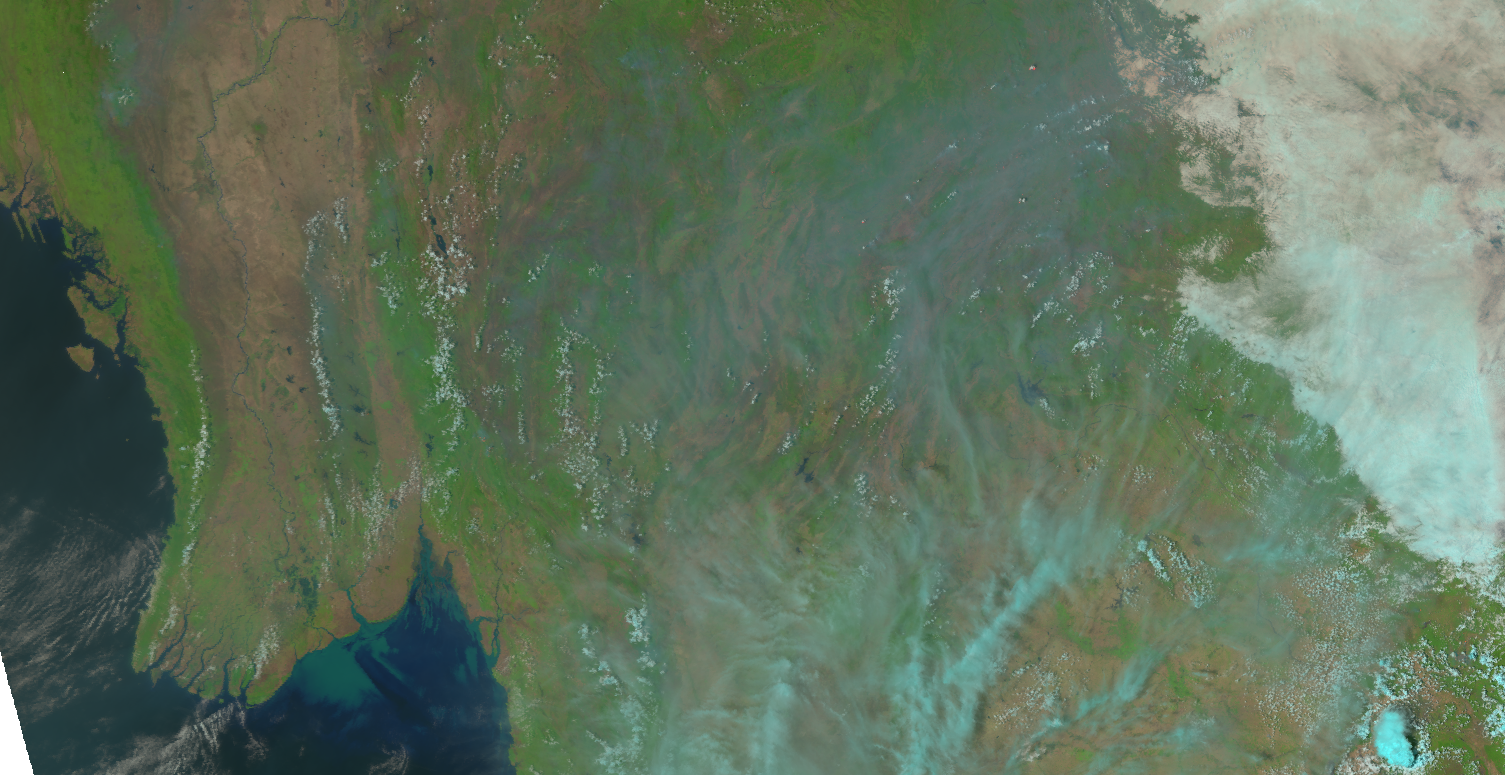

In [68]:
scn_resample_nc.show('natural_color')

<br>

## <a id='vis_natural'></a> 4. Visualize VIIRS *natural_color* RGB composite with Cartopy features

SatPy's built-in visualization function is nice, but often you want to make use of additonal features, such as country borders. The library [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) offers powerful functions that enable the visualization of geospatial data in different projections and to add additional features to a plot. Below, we will show you how you can visualize the `natural_color` composite with the two Python packages [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

As a first step, we have to convert the `Scene` object into a numpy array. The numpy array additionally needs to be transposed to a shape that can be interpreted by matplotlib's function `imshow()`: (M,N,3). You can convert a Scene object into a `numpy.array` object with the function `np.asarray()`. We have to transpose the array and add index=0 on index position 3.

In [69]:
image = np.asarray(scn_resample_nc['natural_color']).transpose(1,2,0)

<br>

The next step is then to replace all nan values with 0. You can do this with the numpy function `nan_to_num()`. In a subsequent step, we then scale the values to the range between 0 and 1, clipping the lower and upper percentiles so that a potential contrast decrease caused by outliers is eliminated.


In [70]:
image = np.nan_to_num(image)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))

<br>

Let us now also define a variable for the `coordinate reference system`. We take the `area` attribute from she `scn_resample_nc` Scene and convert it with the function `to_cartopy_crs()` into a format Cartopy can read. We will use the `crs` information for plotting.

In [71]:
crs = scn_resample_nc['natural_color'].attrs['area'].to_cartopy_crs()

<br>

Now, we can visualize the `natural_color` composite. The plotting code can be divided in four main parts:
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines and a grid**: specify additional features to be added to the plot
* **Plotting function**: plot the numpy array with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

Text(0.5, 1.0, 'Natural color composite around Laos, recorded by VIIRS at 2023-04-07 06:06')

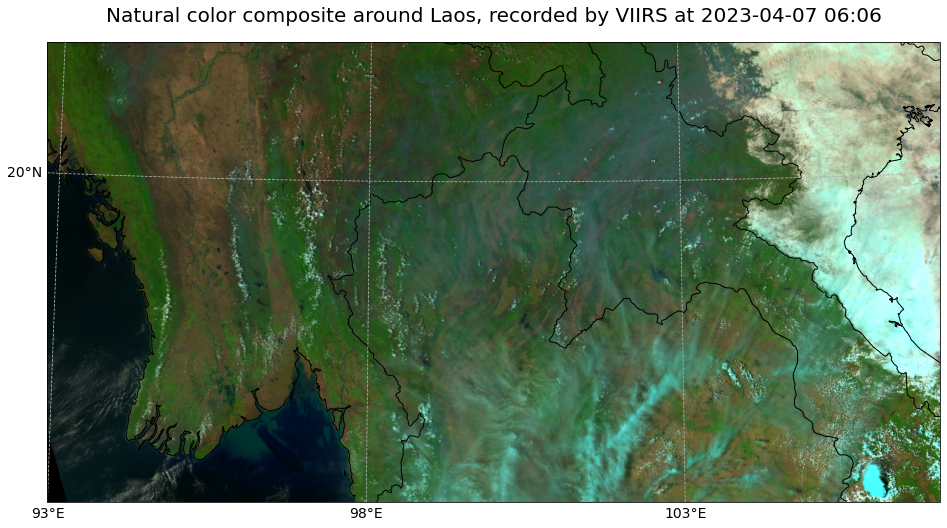

In [73]:
# ... and use it to generate an axes in our figure with the same CRS
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)

# Now we can add some coastlines...
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# ... and a lat/lon grid:
gl = ax.gridlines(draw_labels=True, linestyle='--', xlocs=range(93,107,5), ylocs=range(15,22,5))
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# In the end, we can plot our image data...
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# and add a title to our plot
plt.title("Natural color composite around Laos, recorded by VIIRS at " + scn_resample_nc.start_time.strftime("%Y-%m-%d %H:%M"), fontsize=20, pad=20.0)


<br>

<hr>

### References

* VNP02IMG - VIIRS/NPP Imagery Resolution 6-Min L1B Swath 375m distributed from NASA LAADS DAAC. Available on-line https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/VNP02IMG--5200. doi:10.5067/VIIRS/VNP02IMG.002
* VNP02DNB - VIIRS/NPP Day/Night Band 6-Min L1B Swath 750m distributed from NASA LAADS DAAC. Available on-line https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/VNP02DNB--5200. doi:10.5067/VIIRS/VNP02IMG.002
* VNP02MOD - VIIRS/NPP Moderate Resolution 6-Min L1B Swath 750m distributed from NASA LAADS DAAC. Available on-line https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/VNP02MOD--5200. doi:10.5067/VIIRS/VNP02MOD.002
* VNP03IMG - VIIRS/NPP Imagery Resolution Terrain-Corrected Geolocation 6-Min L1 Swath 375m distributed from NASA LAADS DAAC. Available on-line https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/VNP03IMG--5200. doi:10.5067/VIIRS/VNP03IMG.002
* VNP03DNB - VIIRS/NPP Day/Night Band Moderate Resolution Terrain-Corrected Geolocation 6-Min L1 Swath 750m distributed from NASA LAADS DAAC. Available on-line https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/VNP02DNB--5200. doi:10.5067/VIIRS/VNP02DNB.002
* VNP03MOD - VIIRS/NPP Moderate Resolution Terrain-Corrected Geolocation 6-Min L1 Swath 750m distributed from NASA LAADS DAAC. Available on-line https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP03MOD. doi:10.5067/VIIRS/VNP03MOD.002

* Some code in this notebook was adapted from the following sources:
  * origin: https://python-kurs.github.io/sommersemester_2019/units/S01E07.html
  * copyright: 2019, Marburg University
  * license: CC BY-SA 4.0
  * retrieved: 2023-01-26 Sabrina Szeto



<hr>

<img src='../img/acam_banner.png' alt='Logo EU Copernicus' align='left' width='30%'><br><br><br><br><br>
This project is licensed under <a href="../LICENSE">MIT License</a> and is developed under a Copernicus contract.

<p style="text-align:right;"> <a href='https://training.eumetsat.int'>EUMETSAT Training</a> | <a href='mailto:training@eumetsat.int'>Contact the training team</a></p>